In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from sklearn.model_selection import train_test_split

def load_data(user_ids, path_to_data):
    # Define transformations
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5,), (0.5,))])

    # Load dataset
    dataset = datasets.EMNIST(path_to_data, split='byclass', train=True, download=True, transform=transform)

    # Filter data for selected users
    user_data = {}
    for user_id in user_ids:
        indices = np.where(dataset.targets == user_id)[0]
        user_dataset = Subset(dataset, indices)
        train_idx, val_idx = train_test_split(list(range(len(user_dataset))), test_size=0.2)
        user_data[user_id] = {
            'train': DataLoader(Subset(user_dataset, train_idx), batch_size=32, shuffle=True),
            'val': DataLoader(Subset(user_dataset, val_idx), batch_size=32)
        }

    return user_data

# Example usage
# user_ids = [0, 1, 2, 3, 4]  # Replace with chosen user IDs
# datasets = load_data(user_ids, 'path/to/data')


In [2]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 62)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Create a model instance
# model = SimpleNN()


In [58]:
def federated_averaging(models):
    global_model = SimpleNN()
    global_state_dict = global_model.state_dict()

    for key in global_state_dict.keys():
        global_state_dict[key] = torch.mean(torch.stack([model.state_dict()[key] for model in models]), dim=0)

    global_model.load_state_dict(global_state_dict)
    return global_model

def train_on_clients(datasets, num_rounds=500, client_fraction=0.05):
    global_model = SimpleNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(global_model.parameters())

    num_clients = len(datasets)
    num_selected = int(num_clients * client_fraction)
    loss_list = []
    accuracy_list = []


    for round in range(num_rounds):
        selected_clients = np.random.choice(np.arange(len(datasets)), num_selected, replace=False)
        models = []
        tmp_loss = 0
        tmp_accuracy = 0

        for client in selected_clients:
            model = SimpleNN()
            model.load_state_dict(global_model.state_dict())
            model.train()

            data = torch.tensor(datasets[client]['images'])
            target = torch.tensor(datasets[client]['labels']).type(torch.LongTensor)
            #print(target.shape)
            optimizer.zero_grad()
            output = model(data)
            #print(output.shape)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            tmp_loss +=loss
            pred = torch.argmax(output,dim=1)
            #print(len(pred))
            tmp_accuracy += (pred == target).float().sum()/(len(pred))

            models.append(model)
        accuracy_list.append(tmp_accuracy/len(datasets))

        loss_list.append(tmp_loss/num_selected)
        global_model = federated_averaging(models)

    return global_model,loss_list, accuracy_list


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path_to_data = 'drive/MyDrive/Colab Notebooks/train_data.npy'
user_ids = [0, 1, 2, 3, 4]  # Replace with chosen user IDs
datasets = np.load(path_to_data, allow_pickle=True)
#datasets = load_data(user_ids, path_to_data)
#train_on_clients(datasets)

In [6]:
len(datasets[0])

2

In [59]:
a,b,c = train_on_clients(datasets)

In [45]:
c

[tensor(0.0013),
 tensor(0.0012),
 tensor(0.0012),
 tensor(0.0017),
 tensor(0.0012),
 tensor(0.0014),
 tensor(0.0014),
 tensor(0.0016),
 tensor(0.0012),
 tensor(0.0015),
 tensor(0.0015),
 tensor(0.0016),
 tensor(0.0012),
 tensor(0.0013),
 tensor(0.0012),
 tensor(0.0016),
 tensor(0.0015),
 tensor(0.0015),
 tensor(0.0013),
 tensor(0.0016),
 tensor(0.0014),
 tensor(0.0014),
 tensor(0.0013),
 tensor(0.0015),
 tensor(0.0012),
 tensor(0.0016),
 tensor(0.0015),
 tensor(0.0014),
 tensor(0.0016),
 tensor(0.0012),
 tensor(0.0011),
 tensor(0.0011),
 tensor(0.0015),
 tensor(0.0015),
 tensor(0.0013),
 tensor(0.0014),
 tensor(0.0013),
 tensor(0.0017),
 tensor(0.0014),
 tensor(0.0016),
 tensor(0.0015),
 tensor(0.0013),
 tensor(0.0013),
 tensor(0.0015),
 tensor(0.0015),
 tensor(0.0015),
 tensor(0.0014),
 tensor(0.0015),
 tensor(0.0012),
 tensor(0.0017),
 tensor(0.0012),
 tensor(0.0014),
 tensor(0.0014),
 tensor(0.0016),
 tensor(0.0017),
 tensor(0.0016),
 tensor(0.0016),
 tensor(0.0012),
 tensor(0.0016

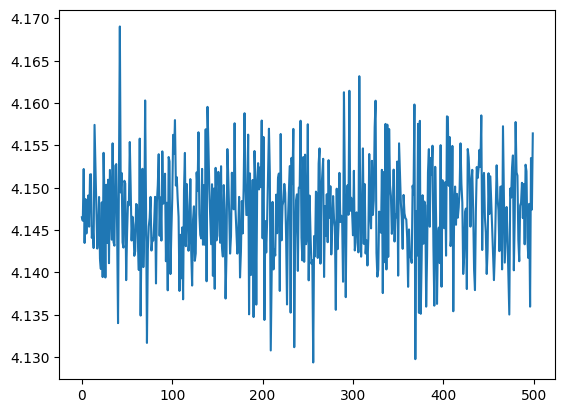

In [60]:
import matplotlib.pyplot as plt
import numpy as np

xpoints = np.arange(len(b))

plt.plot(xpoints, [b_1.detach().numpy() for b_1 in b])
plt.show()

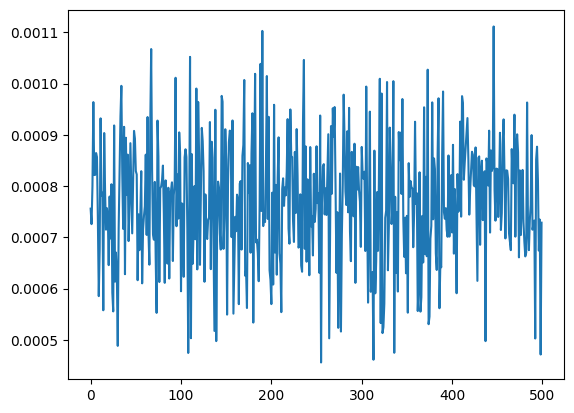

In [61]:
plt.plot(xpoints, [c_1.detach().numpy() for c_1 in c])

In [62]:
#different fraction
a_new,b_new,c_new = train_on_clients(datasets, num_rounds=500, client_fraction=0.1)


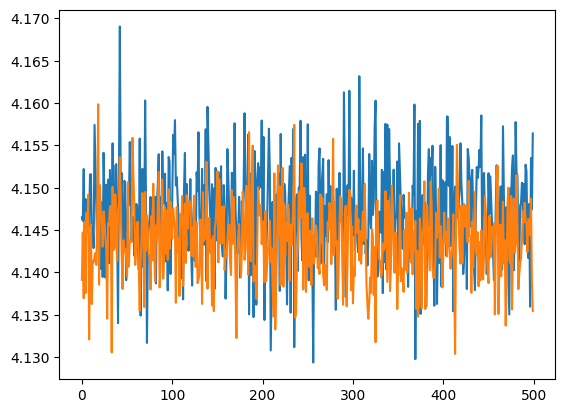

In [63]:
import matplotlib.pyplot as plt
import numpy as np

xpoints = np.arange(len(b))

plt.plot(xpoints, [b_1.detach().numpy() for b_1 in b], [b_1.detach().numpy() for b_1 in b_new])
plt.show()